# PART II : Predicting the language a surname comes from ( ADDED TANH )
In this part we added the tanh activation fuction between the hidden state to the output so that the structure match with Figure 10.3 in Goodfellow's textbook.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('../../data/RNN/data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['../../data/RNN/data/names/Arabic.txt', '../../data/RNN/data/names/Chinese.txt', '../../data/RNN/data/names/Czech.txt', '../../data/RNN/data/names/Dutch.txt', '../../data/RNN/data/names/English.txt', '../../data/RNN/data/names/French.txt', '../../data/RNN/data/names/German.txt', '../../data/RNN/data/names/Greek.txt', '../../data/RNN/data/names/Irish.txt', '../../data/RNN/data/names/Italian.txt', '../../data/RNN/data/names/Japanese.txt', '../../data/RNN/data/names/Korean.txt', '../../data/RNN/data/names/Polish.txt', '../../data/RNN/data/names/Portuguese.txt', '../../data/RNN/data/names/Russian.txt', '../../data/RNN/data/names/Scottish.txt', '../../data/RNN/data/names/Spanish.txt', '../../data/RNN/data/names/Vietnamese.txt']


In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [3]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../../data/RNN/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

## The RNN architecture with tanh activation function

In [5]:
import torch.nn as nn
from torch.nn import functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = F.tanh(self.i2h(combined)) # ADDED TANH HERE !!!!
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
criterion = nn.NLLLoss() 
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

In [7]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()  

In [8]:
import time
import math

n_iters = 300000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


5000 1% (2m 30s) 2.8625 D'cruze / Czech ✗ (Portuguese)
10000 3% (4m 52s) 1.9234 Milligan / Irish ✓
15000 5% (6m 3s) 1.9275 Abasolo / Italian ✗ (Spanish)
20000 6% (6m 29s) 1.4254 Agthoven / Dutch ✓
25000 8% (7m 3s) 0.5273 Duong / Vietnamese ✓
30000 10% (7m 30s) 0.8406 Leclair / French ✓
35000 11% (7m 55s) 1.0677 Slezak / Polish ✗ (Czech)
40000 13% (8m 21s) 2.2626 Michel / Czech ✗ (Polish)
45000 15% (8m 48s) 1.1958 Kloet / Dutch ✓
50000 16% (9m 14s) 0.2933 Vyazmikin / Russian ✓
55000 18% (9m 40s) 4.2967 Simon / English ✗ (Irish)
60000 20% (10m 6s) 0.1646 Diakogeorgiou / Greek ✓
65000 21% (10m 32s) 0.0698 Balakhnin / Russian ✓
70000 23% (10m 59s) 2.5637 Leitner / French ✗ (German)
75000 25% (11m 20s) 0.1848 Sokolofsky / Polish ✓
80000 26% (11m 41s) 3.5247 Whitelaw / Czech ✗ (English)
85000 28% (12m 1s) 0.1600 Seok / Korean ✓
90000 30% (12m 21s) 2.2140 Schetinkin / Dutch ✗ (Russian)
95000 31% (12m 42s) 2.7701 Rompa / Italian ✗ (Dutch)
100000 33% (13m 4s) 1.7957 Schwarzenegger / Czech ✗ (Ge

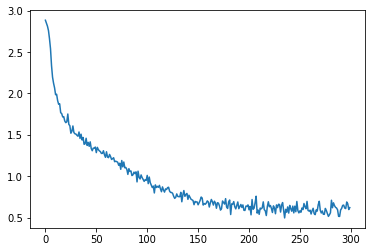

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


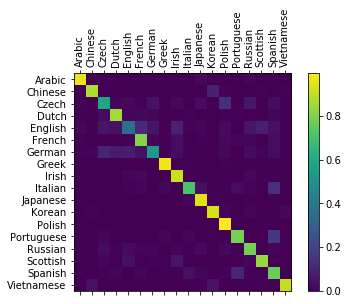

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## RESULTS

In this part we trained an RNN with the same architecture with Goodfellow's Figure 10.3.

There is tanh activation function between the hidden state to the output.

At first, I trained the model for 100000 iters but I noticed that the loss were still decreasing so I trained again for 300000 iters.

Then, we can see int he loss plot that the loss has decreased more and converging better to the value around 0.5.

In the confusion matrix we can see that, compared to the model in part 1 where there is no tanh activation function, this model predict the languages more accurately. As seen that the diagonal boxes are clearer and there are noticably less light-color boxes at other positions.

These results indicate that with tanh the RNN can learn better.